<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 3: Simulated Annealing

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

---------------------------------------------------------------
## (Optional) For Colab

In [ ]:
# from google.colab import drive
# import os, sys
# drive.mount('gdrive', force_remount=True)

---------------------------------------------------------------

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# SA
MAX_EVALUATION = 1000
SUB_ITERATIONS = 100
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

# Plot Settings
PLOT_MODE = True # Draw Route
plt.ion()

# First City Index
FIRST_IDX = 0

In [2]:
file_path = 'data3.txt'

# Step 1. Data Loading

In [3]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

# Step 2. Initialization

In [4]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 2. Hill Climbing (2-opt search)

In [5]:
# 개선 안된 경로도 확률적으로 받아들임 => 확률식을 어떻게 할 것인지?
# T를 천천히 떨어트리다가 나중에 급격하게? (현재는 반대) / 뭐 어쨌든 cooling ratio를 잘 설정하는 것

In [6]:
# opt 선택 기준 -> 가장 긴 간선과 가장 짧은 간선

In [11]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [12]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()
    global TEMPERATURE

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            

    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()

    return best_path, best_cost

# Main

In [13]:
file_path = 'data1.txt'

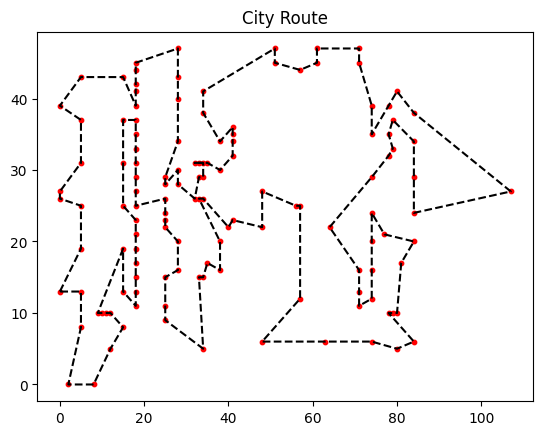

Execution Time: 3.642899990081787
Path: [0, 6, 7, 1, 2, 8, 9, 3, 10, 23, 39, 40, 41, 42, 43, 60, 59, 58, 57, 51, 50, 56, 55, 61, 65, 69, 70, 66, 62, 75, 78, 82, 83, 84, 85, 79, 71, 72, 90, 89, 94, 95, 96, 103, 102, 110, 109, 116, 121, 128, 130, 125, 126, 127, 119, 115, 118, 114, 108, 98, 101, 100, 99, 104, 105, 106, 107, 112, 124, 123, 120, 117, 113, 129, 122, 111, 97, 88, 92, 93, 91, 87, 86, 81, 80, 68, 64, 77, 76, 74, 67, 63, 73, 52, 44, 45, 53, 54, 46, 47, 48, 49, 32, 33, 34, 35, 36, 37, 38, 22, 21, 20, 31, 30, 29, 28, 27, 26, 25, 18, 19, 13, 14, 15, 16, 24, 17, 12, 4, 11, 5, 0]
Cost: 618.3955248218386


In [14]:
# Initialization ###############
initialize = initialize_greedy
#initialize = initialize_random
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2
path_map, path = initialize(coord_list, FIRST_IDX)

# Step 3
best_path, best_cost = sa(path_map, path, coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))